# Qubitization based Quantum Phase Estimation (QPE) for Solving Molecular Energies

This notebook is based on Ref. [[1](#walk_qpe)]. Given an efficient block-encoding for a Hamiltonian, this algorithm preforms an efficient Quantum Phase Estimation.

The core quantum function of this model uses almost all Qmod built-in operations: `control`, `power`, `within_apply`, and `invert`.

The algorithm assumes we have the block-encoding of a matrix $H$
$$
U_{(s,m)-H} =\begin{pmatrix}
H/s & * \\
* & *
\end{pmatrix},
$$
with $m$ being the size of the block variable and $s$ some scaling factor.
Given this quantum function, we can define the following unitary (usually called the Szegedy quantum walk operator [[2](#ref-szegedy)]):
$$
W\equiv \Pi_{|0\rangle_m} U_{(s,m)-H},
$$  
where $\Pi_{|0\rangle_m}$ is a reflection operator about the block state 0.

The spectrum of the walk operator has a nice relation to the spectrum of the block-encoded Hamiltonian [[3](#ref-lin)]:
  $$
  \text{eigenvalues: } e^{\pm i \arccos(\lambda/s)}, \text{ with eigenvectors:  } |\varphi^{\pm}_{\lambda}\rangle \equiv \frac{1}{\sqrt{2}}\left(|v_{\lambda}\rangle |0\rangle_m \pm i|\perp_{\lambda}\rangle\right), \quad (1)
  $$
where $|v_\lambda\rangle$ is an eigenstate of the Hamiltonian $H$ with an eigenvalue $\lambda$.
Namely, the *eigenphases* of $H$ are related by some nonlinear function ($\arccos$) to the *eigenvalues* of $H$.

**The algorithm works under the assumption that the block-encoding unitary itself is also Hermitian, that is, $U_{(s,m)-H}$ is Unitary and Hermitian.**


## Preliminaries

We start with defining some utility functions that are not implemented as part of Classiq, and might be included in the future. These functions are used for the specific block-encoding used in this notebook. 

In [1]:
!pip install -qq "classiq[chemistry]"

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import *
from classiq.applications.chemistry.op_utils import qubit_op_to_qmod

In [3]:
from sympy import fwht

from classiq.open_library.functions.state_preparation import apply_phase_table


def get_graycode(size, i) -> int:
    if i == 2**size:
        return get_graycode(size, 0)
    return i ^ (i >> 1)


def get_graycode_angles_wh(size, angles):
    transformed_angles = fwht(np.array(angles) / 2**size)
    return [transformed_angles[get_graycode(size, j)] for j in range(2**size)]


def get_graycode_ctrls(size):
    return [
        (get_graycode(size, i) ^ get_graycode(size, i + 1)).bit_length() - 1
        for i in range(2**size)
    ]


@qfunc
def multiplex_ra(a_y: float, a_z: float, angles: list[float], qba: QArray, ind: QBit):
    assert a_y**2 + a_z**2 == 1
    # TODO support general (0,a_y,a_z) rotation
    assert (
        a_z == 1.0 or a_y == 1.0
    ), "currently only strict y or z rotations are supported"
    size = max(1, (len(angles) - 1).bit_length())
    extended_angles = angles + [0] * (2**size - len(angles))
    transformed_angles = get_graycode_angles_wh(size, extended_angles)
    controllers = get_graycode_ctrls(size)

    for k in range(2**size):
        if a_z == 0.0:
            RY(transformed_angles[k], ind)
        else:
            RZ(transformed_angles[k], ind)

        skip_control(lambda: CX(qba[controllers[k]], ind))


@qfunc
def lcu_paulis_graycode(terms: list[SparsePauliTerm], data: QArray, block: QArray):
    n_qubits = data.len
    n_terms = len(terms)
    table_z = np.zeros([n_qubits, n_terms])
    table_y = np.zeros([n_qubits, n_terms])
    probs = [abs(term.coefficient) for term in terms] + [0.0] * (2**block.len - n_terms)
    hamiltonian_coeffs = np.angle([term.coefficient for term in terms]).tolist() + [
        0.0
    ] * (2**block.len - n_terms)
    accumulated_phase = np.zeros(2**block.len).tolist()

    for k in range(n_terms):
        for pauli in terms[k].paulis:
            if pauli.pauli == Pauli.Z:
                table_z[pauli.index, k] = -np.pi
                accumulated_phase[k] += np.pi / 2
            elif pauli.pauli == Pauli.Y:
                table_y[pauli.index, k] = -np.pi
                accumulated_phase[k] += np.pi / 2
            elif pauli.pauli == Pauli.X:
                table_z[pauli.index, k] = -np.pi
                table_y[pauli.index, k] = np.pi
                accumulated_phase[k] += np.pi / 2

    def select_graycode(block: QArray, data: QArray):
        for i in range(n_qubits):
            multiplex_ra(0, 1, table_z[i, :], block, data[i])
            multiplex_ra(1, 0, table_y[i, :], block, data[i])
        apply_phase_table(
            [p1 - p2 for p1, p2 in zip(hamiltonian_coeffs, accumulated_phase)], block
        )

    within_apply(
        lambda: inplace_prepare_state(probs, 0.0, block),
        lambda: select_graycode(block, data),
    )

## Defining a specific usecase: a Molecule and its block-encoding Hamiltonian function

In [4]:
molecule_H2_geometry = [("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, 0.735))]

In [5]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

basis = "sto-3g"  # Basis set
multiplicity = 1  # Singlet state S=0
charge = 0  # Neutral molecule
molecule = MolecularData(molecule_H2_geometry, basis, multiplicity, charge)

molecule = run_pyscf(
    molecule,
    run_fci=True,  # relevant for small, classically solvable problems
)

In [6]:
from classiq.applications.chemistry.mapping import FermionToQubitMapper
from classiq.applications.chemistry.problems import FermionHamiltonianProblem

# Define a  Hamiltonian in an active space
problem = FermionHamiltonianProblem.from_molecule(molecule=molecule)
mapper = FermionToQubitMapper()

qubit_hamiltonian = mapper.map(problem.fermion_hamiltonian)
print("Your Hamiltonian is", qubit_hamiltonian, sep="\n")

Your Hamiltonian is
(-0.09057898608834769+0j) [] +
(0.04523279994605784+0j) [X0 X1 X2 X3] +
(0.04523279994605784+0j) [X0 X1 Y2 Y3] +
(0.04523279994605784+0j) [Y0 Y1 X2 X3] +
(0.04523279994605784+0j) [Y0 Y1 Y2 Y3] +
(0.17218393261915538+0j) [Z0] +
(0.12091263261776627+0j) [Z0 Z1] +
(0.16892753870087907+0j) [Z0 Z2] +
(0.1661454325638241+0j) [Z0 Z3] +
(-0.2257534922240238+0j) [Z1] +
(0.1661454325638241+0j) [Z1 Z2] +
(0.17464343068300453+0j) [Z1 Z3] +
(0.1721839326191554+0j) [Z2] +
(0.12091263261776627+0j) [Z2 Z3] +
(-0.22575349222402386+0j) [Z3]


Finally, we calculate the ground state energy as a reference solution to the quantum solver

In [7]:
classical_sol = molecule.fci_energy
print(f"Expected energy: {classical_sol} Ha")

Expected energy: -1.1373060357533995 Ha


In [8]:
mol_hamiltonian = qubit_op_to_qmod(qubit_hamiltonian)
num_qubits = mol_hamiltonian.num_qubits
be_scaling = sum(np.abs(term.coefficient) for term in mol_hamiltonian.terms)
normalized_mol_hamiltonian = mol_hamiltonian * (1 / be_scaling)

In [9]:
data_size = normalized_mol_hamiltonian.num_qubits
num_terms = len(normalized_mol_hamiltonian.terms)
block_size = (num_terms - 1).bit_length() if num_terms != 1 else 1

In [10]:
print(f"The block size is {block_size}, and the scaling factor s is : {be_scaling}")

The block size is 4, and the scaling factor s is : 1.9850721353060015


In [11]:
class BlockEncodedState(QStruct):
    data: QNum[data_size]
    block: QNum[block_size]


@qfunc
def be_hamiltonian(state: BlockEncodedState):
    lcu_paulis_graycode(normalized_mol_hamiltonian.terms, state.data, state.block)

## Defining a Walk Operator

We use the `reflect_around_zero` function from Classiq's open library to define a walk operator function with the declaration below. This function implements $I-2|0\rangle\langle 0|$, so we must insert a minus phase (This can be done by adding a minus sign using the `phase` function). 

In [12]:
from classiq.qmod.symbolic import pi


@qfunc
def my_reflect_about_zero(qba: QNum):
    control(qba == 0, lambda: phase(pi))
    phase(pi)


@qfunc
def walk_operator(
    be_qfunc: QCallable[BlockEncodedState], state: BlockEncodedState
) -> None:
    be_qfunc(state)
    my_reflect_about_zero(state.block)

We define a classical function that takes the eigenphases of the Walk operator, and returns the (scaled) eigenvalues of $H$, according to equation (1) above.

In [13]:
def post_process_walk_phases(w_eigphase, be_scaling):
    return np.cos(2 * np.pi * w_eigphase) * be_scaling

We also define a utility function for ploting the results:

In [14]:
def get_qpe_walk_result(df, be_scaling, to_plot=True):
    filtered_block_res = df[df["block"] == 0].copy()
    block_prob = df.loc[df["block"] == 0, "probability"].sum()
    print(f"probability to measure the block variable at state zero: {block_prob}")
    filtered_block_res["post_processed_phases"] = post_process_walk_phases(
        filtered_block_res["phase_var"], be_scaling
    )

    max_prob_energy = filtered_block_res.loc[
        filtered_block_res["probability"].idxmax(), "post_processed_phases"
    ]
    print(f"\nEnergy with maximal probability: {max_prob_energy} Ha")

    if to_plot:
        plt.plot(
            filtered_block_res["post_processed_phases"],
            filtered_block_res["probability"],
            "o",
        )
        plt.xlabel("Energy (Ha)", fontsize=16)
        plt.ylabel("P(Energy)", fontsize=16)
        plt.tick_params(axis="both", labelsize=16)
        plt.title("Energy Histogram from QPE")

    return filtered_block_res

## Setting initial state and QPE size

In [15]:
from classiq.applications.chemistry.hartree_fock import get_hf_state

# We take the Hartree Fock state
hf_state = get_hf_state(problem, mapper)

QPE_SIZE = 5

## A Naive QPE

Before going to the optimized implementation, designing a specific QPE that operates on a walk operator, we start with a naive QPE implementation. 

In [16]:
@qfunc
def main(
    block: Output[QNum[block_size]],
    phase_var: Output[QNum[QPE_SIZE, SIGNED, QPE_SIZE]],
) -> None:

    data = QNum(size=data_size)
    prepare_basis_state(hf_state, data)
    allocate(block)

    allocate(phase_var)
    qpe(lambda: walk_operator(be_hamiltonian, [data, block]), phase_var)
    drop(data)


qprog_qpe_naive = synthesize(main)
show(qprog_qpe_naive)

Quantum program link: https://platform.classiq.io/circuit/38VyDBs3xcSfRT772EkonhMeqwA


In [17]:
results_qpe_naive = execute(qprog_qpe_naive).get_sample_result()

Classical solution:, -1.1373060357533995 Ha
probability to measure the block variable at state zero: 0.50732421875

Energy with maximal probability: -1.102846988772674 Ha


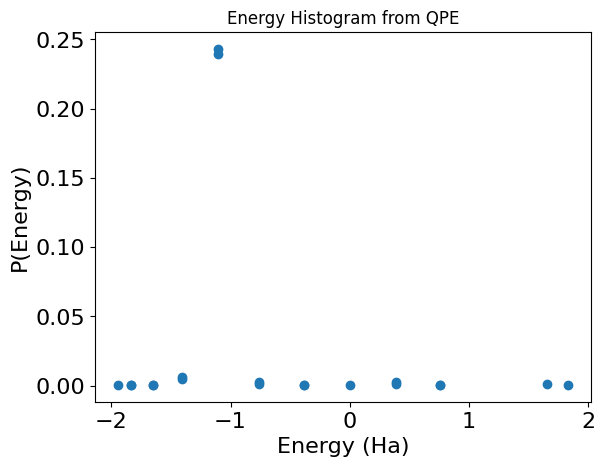

In [18]:
df_qpe_naive = results_qpe_naive.dataframe
print(f"Classical solution:, {classical_sol} Ha")
post_processed_df_qpe_naive = get_qpe_walk_result(
    df_qpe_naive, be_scaling, to_plot=True
)

## Optimized QPE design for the walk operator

We construct the model design according to Ref. [[1](#walk_qpe)], shown in the figure below, with $R_{\mathcal{L}}$ being the reflection around zero operation, and $\chi_m$ is taken as the usual Hadamard transform for the phase initialization:

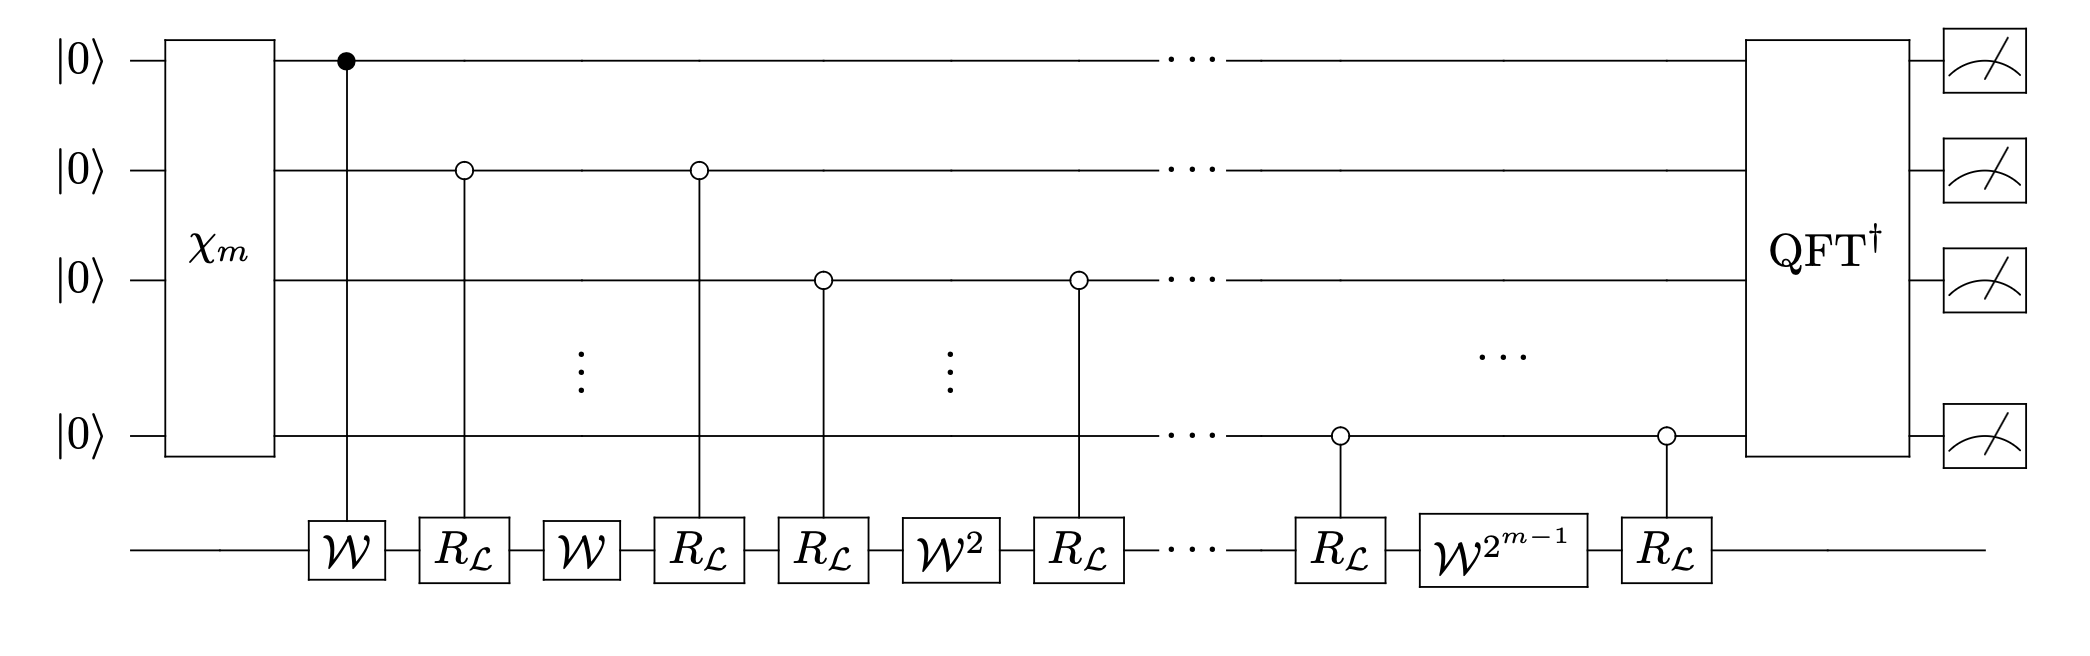

In [19]:
@qfunc
def qpe_on_walk(
    block_encoding: QCallable[BlockEncodedState],
    state: BlockEncodedState,
    phase_var: QArray,
) -> None:

    hadamard_transform(phase_var)
    control(
        phase_var[0],
        lambda: walk_operator(block_encoding, state),
    )
    repeat(
        count=phase_var.len - 1,
        iteration=lambda i: within_apply(
            lambda: control(
                phase_var[i + 1] == 0,
                lambda: control(state.block == 0, lambda: phase(pi)),
            ),
            lambda: power(2**i, lambda: walk_operator(block_encoding, state)),
        ),
    )
    invert(lambda: qft(phase_var))

We now construct the model, synthesize it, and retrieve the ground state of the molecule

In [20]:
@qfunc
def main(
    block: Output[QNum[block_size]],
    phase_var: Output[QNum[QPE_SIZE, SIGNED, QPE_SIZE]],
) -> None:

    data = QNum(size=data_size)
    prepare_basis_state(hf_state, data)
    allocate(block)
    allocate(phase_var)

    qpe_on_walk(block_encoding=be_hamiltonian, state=[data, block], phase_var=phase_var)
    drop(data)


qprog_qpe_walk = synthesize(main)
show(qprog_qpe_walk)

Quantum program link: https://platform.classiq.io/circuit/38VyLEYiNJ1PXIRn5XDbpa2V6MN


In [21]:
results_qpe_walk = execute(qprog_qpe_walk).get_sample_result()

Classical solution:, -1.1373060357533995 Ha
probability to measure the block variable at state zero: 0.47119140625

Energy with maximal probability: -1.102846988772674 Ha


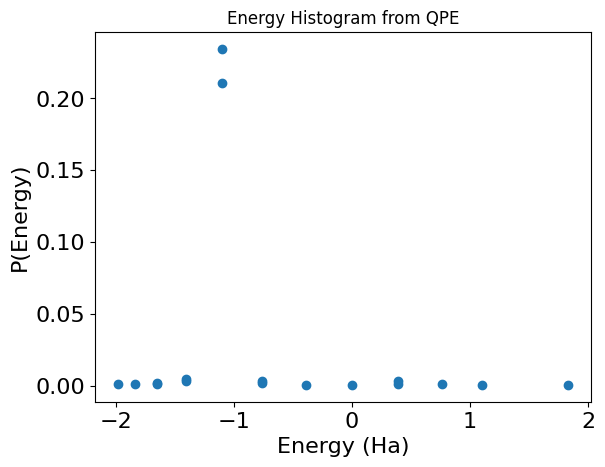

In [22]:
df_qpe_optimized = results_qpe_walk.dataframe
print(f"Classical solution:, {classical_sol} Ha")
post_processed_df_qpe_optimized = get_qpe_walk_result(
    df_qpe_optimized, be_scaling, to_plot=True
)

In [23]:
print("For the naive QPE on the walk operator:")
print(f"depth: {qprog_qpe_naive.transpiled_circuit.depth}")
print("=" * 40)
print("For the optimized QPE on the walk operator:")
print(f"depth: {qprog_qpe_walk.transpiled_circuit.depth}")
print("=" * 40)

For the naive QPE on the walk operator:
depth: 19686
For the optimized QPE on the walk operator:
depth: 4724


In [24]:
gs_naive = post_processed_df_qpe_naive.loc[
    post_processed_df_qpe_naive["probability"].idxmax(), "post_processed_phases"
]
gs_optimized = post_processed_df_qpe_optimized.loc[
    post_processed_df_qpe_optimized["probability"].idxmax(), "post_processed_phases"
]

If $\Delta \lambda_W = 1/2^{\rm QPE-SIZE}$, then
$$
\Delta \lambda = \Delta(\cos(2\pi\lambda_W))s = 2\pi s \sin(2\pi\lambda_W) \Delta\lambda_W = 2\pi s \sin(2\pi 2^{-\rm QPE-SIZE}) 2^{-\rm QPE-SIZE}
$$

In [25]:
qpe_err = (
    2 * np.pi * be_scaling * np.sin(2 * np.pi * (1 / 2**QPE_SIZE)) * (1 / 2**QPE_SIZE)
)

In [26]:
print(f"QPE error: {qpe_err}")

QPE error: 0.07603996508423008


In [27]:
assert np.abs(gs_naive - classical_sol) < qpe_err
assert np.abs(gs_optimized - classical_sol) < qpe_err

## References
<a name="walk_qpe">[1]</a> R. Babbush et. al., Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity. [https://arxiv.org/abs/1805.03662 (2018)](https://arxiv.org/abs/1805.03662)

<a name="ref-szegedy">[2]</a> Szegedy, M. , Quantum speed-up of Markov chain based algorithms. [In 5th Annual IEEE Symposium on Foundations of Computer Science (2004)](https://ieeexplore.ieee.org/abstract/document/1366222)

<a name="ref-lin">[3]</a> Lin, L., Lecture notes on quantum algorithms for scientific computation. [arXiv:2201.08309 quant-ph (2022)](https://arxiv.org/abs/2201.08309)